姓名：申尚东

学号：2016011378

学院：软件学院

专业：软件工程

实训作业一：CAlustering Schoolwork

In [173]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
#导入iris数据集和结点文件
df = pd.read_csv('F:/Iris/iris_data.txt',header=None)
layout = pd.read_csv('F:/Iris/iris_layout.txt',sep=' ',header=None)

In [175]:
#将iris数据集的标签进行编码，并将数据与标签分开，label为标签，data为数据集
layout = np.array(layout)
label_mapping={'Iris-versicolor':2,'Iris-setosa':1,'Iris-virginica':0}
label = np.array(df[4].map(label_mapping))
data = np.array(df[[1,2,3]])

In [176]:
#计算相似度矩阵sim
from sklearn.metrics.pairwise import cosine_similarity
sim=cosine_similarity(data)

In [177]:
#计算近邻矩阵（取每个点的最相似的16个点的索引）n为近邻矩阵
n =[]
for i in range(len(sim)):
    inds = np.argsort(sim[i])
    inds = inds[-16:-1]
    n.append(inds)

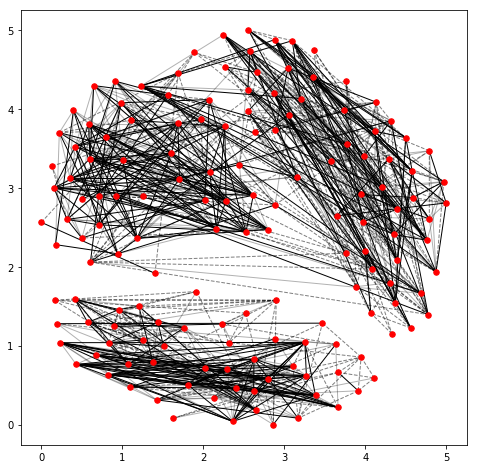

In [178]:
#将鸢尾花数据集可视化（聚类之前）
plt.figure(figsize=(8,8))
G = nx.Graph()
#添加点
G.add_nodes_from([i for i in range(150)])
#添加边
for i in range(len(sim)):
    for j in range(len(sim)):
        if(i in n[j] and j in n[i]):
            G.add_edge(i,j,weight=sim[i,j])
        else:
            sim[i,j] = 0
#画出结点
nx.draw_networkx_nodes(G,layout,node_color='r',node_size=30,node_shape='o')
#将图G中的边按照权重分组
edges_list1=[]
edges_list2=[]
edges_list3=[]
for(u,v,d) in G.edges(data='weight'):
    if d>0.9998:
        edges_list1.append((u,v))
    elif d>0.9996:
        edges_list2.append((u,v))
    else:
        edges_list3.append((u,v))
#以不同样式画出三组的边
nx.draw_networkx_edges(G,layout,edgelist=edges_list1,width=1,alpha=1.0,edge_color='k',style='solid')
nx.draw_networkx_edges(G,layout,edgelist=edges_list2,width=1,alpha=0.3,edge_color='k',style='solid')
nx.draw_networkx_edges(G,layout,edgelist=edges_list3,width=1,alpha=0.5,edge_color='k',style='dashed')
plt.savefig('iris_graph.png')
plt.show()

In [179]:
#运用谱聚类的归一割，取归一化对称拉普拉斯矩阵的前3小的特征值对应的特征向量Vectors
A = sim  #相似度矩阵
D = np.diag(A.sum(axis=0))  #度数矩阵
L = D - A #拉普拉斯矩阵
D = np.linalg.inv(np.sqrt(D))
L = D.dot(L).dot(D)  #对称拉普拉斯矩阵
w,v = np.linalg.eig(L)  #求出L的特征值和特征向量
inds = np.argsort(w)[:3] #求出前三小的特征值对应的下标
Vectors = v[:,inds]   #前三小的特征向量
normalizer = np.linalg.norm(Vectors,axis=1)
normalizer = np.repeat(np.transpose([normalizer]),3,axis=1)
Vectors = Vectors / normalizer #归一化

In [180]:
#用k-means方法对归一化堆成拉普拉斯矩阵聚类
#随机选择3个点作为质心点
centroids_idx = np.random.choice(Vectors.shape[0],size=3)
centroids = Vectors[centroids_idx]
centroids = np.array(centroids)
print(centroids)

[[-2.26150491e-01  6.92710404e-01 -6.84841771e-01]
 [-9.99993424e-01 -3.62654777e-03 -2.89873292e-16]
 [-1.71404981e-01  5.25022137e-01 -8.33649859e-01]]


In [181]:
#不断以新的质心聚类，并计算新的质心，直到迭代次数到达上限或者质心变化小于某阈值
max_iter = 300 #最大迭代次数
epsilon = 0.001  #阈值
a = 0
#根据质心聚类的函数
def split_cluster(Vectors,centroids):
    clusters = [[] for i in range(centroids.shape[0])]
    for i in range(Vectors.shape[0]):
        dist = np.square(Vectors[i]-centroids).sum(axis=1)
        idx = np.argmin(dist)
        clusters[idx].append(i)
    return(np.array(clusters))
#更新质心的函数
def update_centroids(clusters,Vectors):
    n_features = Vectors.shape[1]
    k = clusters.shape[0]
    centroids = np.zeros((k,n_features))
    for i,cluster in enumerate(clusters):
        centroid = np.mean(Vectors[cluster],axis=0)
        centroids[i] = centroid
    return(centroids)
#求出聚类好的分布矩阵clusters,其中每行代表一个类，每行的数据是点的索引值
for _ in range(max_iter):
    clusters = split_cluster(Vectors,centroids)
    former_centroids = centroids
    centroids = update_centroids(clusters,Vectors)
    diff = centroids - former_centroids
    if diff.any() < epsilon:
        break

In [182]:
#根据聚类好的分布矩阵clusters预测出Vectors每行数据对应的标签
y_pred = np.zeros(Vectors.shape[0],dtype=np.int64)
for cluster_i,cluster in enumerate(clusters):
    for sample_i in cluster:
        y_pred[sample_i] = cluster_i
y_pred

array([2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 0,
       1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0,
       2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2,
       0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 1, 1, 0, 1, 1,
       2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0,
       0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 0, 1], dtype=int64)

In [183]:
label #实际Vectors每行对应的标签

array([2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 0,
       1, 2, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0,
       2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2,
       0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       1, 0, 1, 1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 0, 1, 1,
       2, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 0, 1, 0,
       0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 0, 1], dtype=int64)

In [184]:
#计算聚类的正确率acc
cnt = 0
for i in range(150):
    if label[i] == y_pred[i]:
        cnt += 1
acc = cnt / 150
acc

0.9333333333333333

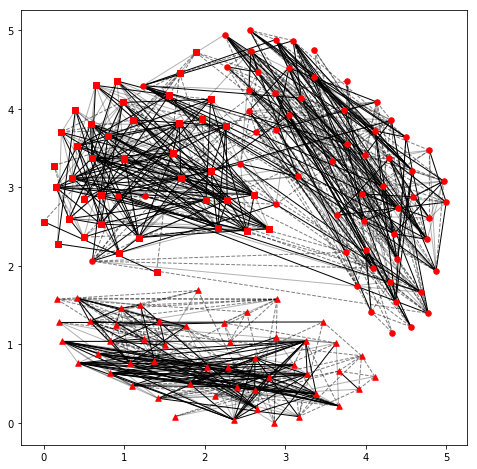

In [185]:
#画出聚类后的可视化图，结点形状表示类别
#创建画布，创建图
plt.figure(figsize=(8,8))
N = nx.Graph()
#添加结点和边
N.add_nodes_from([i for i in range(150)])
for i in range(len(sim)):
    for j in range(len(sim)):
        if(i in n[j] and j in n[i]):
            N.add_edge(i,j,weight = sim[i,j])
#根据边的权重将边分为三类
edges_list1 = []
edges_list2 = []
edges_list3 = []
for (u,v,d) in N.edges(data='weight'):
    if d>0.9998:
        edges_list1.append((u,v))
    elif d>0.9996:
        edges_list2.append((u,v))
    else:
        edges_list3.append((u,v))
#画出结点        
nx.draw_networkx_nodes(N, layout, node_size=30, nodelist=clusters[0], node_shape='o')
nx.draw_networkx_nodes(N, layout, node_size=30, nodelist=clusters[1], node_shape='^')
nx.draw_networkx_nodes(N, layout, node_size=30, nodelist=clusters[2], node_shape='s')
#画出边
nx.draw_networkx_edges(N,layout,edgelist=edges_list1,width=1,alpha=1.0,edge_color='k',style='solid')
nx.draw_networkx_edges(N,layout,edgelist=edges_list2,width=1,alpha=0.3,edge_color='k',style='solid')
nx.draw_networkx_edges(N,layout,edgelist=edges_list3,width=1,alpha=0.5,edge_color='k',style='dashed')
#保存图片
plt.savefig('cl_iris_graph.png')
plt.show()